<a href="https://colab.research.google.com/github/adalbertii/21.04.2023-python-notebooks-package/blob/main/wmi_keras_convolutional_netowork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Educational Friday: 21.04.2023**

---
Developed by Wojciech Michalski

---



# Construction of convolutional neural networks - binary classification case





Using the Keras library

> Convolutional networks learn local patterns. The patterns recognized by the convolutional network are independent of their position in the image.
 
 > The advantage of CNN is the ability to teach a spatial hierarchy of patterns. The first layers learn small local patterns, such as edges, and subsequent layers will learn larger structures consisting of elements recognized by the initial layers.

 

### Importing required libraries


In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

### Download training and test data
We will download the data from Amazon S3 storage.

The name of the bucket is: `ml-repository-crackers`.

The zipped file `dogs-vs-cats.zip` is just over 812 MB and is stored in the EU (Ireland) region.

In [2]:
%%bash
rm -rf /content/*

pwd
wget --output-document=cats_and_dogs.zip --quiet https://ml-repository-krakers.s3-eu-west-1.amazonaws.com/kaggle+/cats_and_dogs/dogs-vs-cats.zip
ls

/content
cats_and_dogs.zip


# Data unpacking

In [3]:
%%bash
unzip cats_and_dogs.zip
# rm -rf cats_and_dogs.zip

rm -rf sampleSubmission.csv

unzip -q train.zip -d /content/kaggle_original_data
rm -rf train.zip
cp /content/kaggle_original_data/train/* /content/kaggle_original_data/
rm -rf /content/kaggle_original_data/train
 
unzip -q /content/test1.zip
# rm -rf test1.zip
# rm -rf cats_and_dogs.zip
ls

Archive:  cats_and_dogs.zip
  inflating: sampleSubmission.csv    
  inflating: train.zip               
  inflating: test1.zip               
cats_and_dogs.zip
kaggle_original_data
test1
test1.zip


# Preparation of the appropriate directory structure

The data will be stored in the directory:

> `/content/cats_and_dogs`

We will divide this directory into three subdirectories:
 * train
 * valid
 * test

In the training set, we will put 2,000 samples (1,000 photos of dogs and 1,000 photos of cats), 1,000 samples (500 photos of dogs and 500 photos of cats) will go to the validation set, and the last 1,000 samples (500 photos of dogs and 500 photos of cats) will go to the test set.

In [4]:

original_dataset_dir = '/content/kaggle_original_data'

base_dir = '/content/cats_and_dogs'

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')    
valid_dir = os.path.join(base_dir, 'valid')    
test_dir = os.path.join(base_dir, 'test')     

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)
    
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

dirs = [train_cats_dir, train_dogs_dir, valid_cats_dir, valid_dogs_dir, test_cats_dir, test_dogs_dir]

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)


# separate the fhotos
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)
    

Checking the correctness of the division


In [5]:
print('Number of cats - training set', len(os.listdir(train_cats_dir)))
print('Number of cats - validation set', len(os.listdir(valid_cats_dir)))
print('Number of cats - test set', len(os.listdir(test_cats_dir)))

print('Number of dogs - training set', len(os.listdir(train_dogs_dir)))
print('Number of dogs - validation set', len(os.listdir(valid_dogs_dir)))
print('Number of dogs - test set', len(os.listdir(test_dogs_dir)))


Number of cats - training set 1000
Number of cats - validation set 500
Number of cats - test set 500
Number of dogs - training set 1000
Number of dogs - validation set 500
Number of dogs - test set 500


### Look at the sample pictures - cats and dogs
> Tip: Use the slider on the right to select a different image index.

In [6]:
import PIL
import PIL.Image

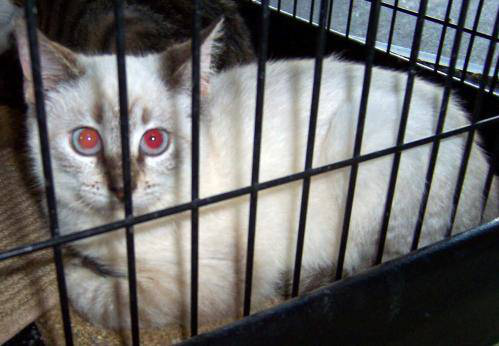

In [7]:
index = 438 #@param {type:'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/cats/cat.' + str(index) +'.jpg'
PIL.Image.open(img_path)

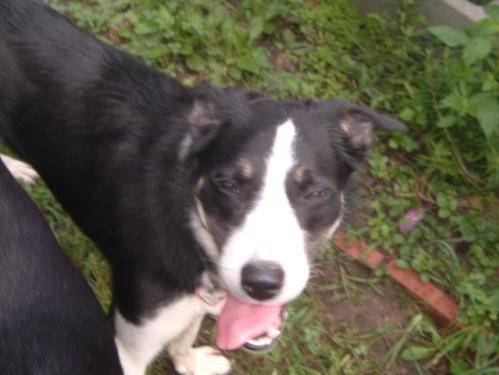

In [8]:
index = 438 #@param {type:'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/dogs/dog.' + str(index) +'.jpg'
PIL.Image.open(img_path)

### Helpful function definition

In [9]:
def make_accuracy_plot(history):
    """
    Funkcja zwraca wykres dokładności (accuracy) modelu na zbiorze treningowym
    i walidacyjnym.
    """
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label='Dokładność trenowania', marker='o')
    plt.plot(epochs, val_acc, label='Dokładność walidacji', marker='o')
    plt.legend()
    plt.title('Dokładność trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Dokładność')
    plt.show()

def make_loss_plot(history):
    """
    Funkcja zwraca wykres straty (loss) modelu na zbiorze treningowym
    i walidacyjnym.
    """
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, loss, label='Strata trenowania', marker='o')
    plt.plot(epochs, val_loss, label='Strata walidacji', marker='o')
    plt.legend()
    plt.title('Strata trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Strata')
    plt.show()
    
def display_augmented_images(directory, index):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[index]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(20, 14))
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

### Building the model


> The Conv2D layer is a convolution layer in which at least three parameters must be specified: 
- the number of filters that will extract the features, 
- the size of the kernel (the size of the convolution window, usually 3x3 or 5x5) and 
- the activation function (the most commonly used `relu` function). 

In addition, in the first layer, you must specify the `input_shape` parameter, which takes the size of the input data. In our case `(150, 150, 3)`. The first two values ​​determine the width and height of the image, while the third determines the color depth, in this case 3.

> The MaxPooling2D layer is a scaling operation. In simple terms, it consists in reducing dimensionality by passing through the image with extraction windows that return the maximum observed value in a given window (usually a 2x2 window size, with a shift step of 2), thus helping to reduce the size of the input data to the next layer by half, which significantly speeds up the process learning.

> The Flatten layer flattens our data in order to combine them with dense layers at the end of building the model. The last activation function will be the `sigmoid` function, which will return the probabilities of the image belonging to a particular class.

In [10]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0


### Model compilation



In [11]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

### Step 5 - Processing the data into the model

Since our data is non-standardized (different sizes of images), we need to process it so that it is presented in the form of tensors of floating point values ​​(float). Our data is currently in JPG files. In the data processing process, the `ImageDataGenerator` class built into `Keras` will help us. All images from the training and validation sets will be scaled to 150x150 pixels.

#### In short, we will do:
- upload files in JPG format
- decode JPG format to pixel grid in RGB format
- save the data in the tensor format of floating point numbers
- scale the pixel values ​​to the range [0, 1] (neural networks are better at dealing with small input values)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# we scale all images by a factor of 1/255
train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Checking the correct shape of the training data

In [13]:
for data_batch, labels_batch in train_generator:
    print('Batch data shape:', data_batch.shape)
    print('Batch data label shape:', labels_batch.shape)
    break

Batch data shape: (20, 150, 150, 3)
Batch data label shape: (20,)


### Model training

We will save the trained model to the file `cats_and_dogs_small_1.h5`.



In [14]:
import time

tic = time.time()
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=100,
                             epochs=20,
                             validation_data=valid_generator,
                             validation_steps=50)

toc = time.time()
print('Czas przetwarzania: {}'.format(toc - tic))
model.save('cats_and_dogs_small_1.h5')

Epoch 1/20
100/100 [==============================] - 13s 100ms/step - loss: 0.6900 - accuracy: 0.5460 - val_loss: 0.6792 - val_accuracy: 0.5200
Epoch 2/20
100/100 [==============================] - 10s 99ms/step - loss: 0.6577 - accuracy: 0.6030 - val_loss: 0.6674 - val_accuracy: 0.5840
Epoch 3/20
100/100 [==============================] - 10s 98ms/step - loss: 0.6185 - accuracy: 0.6525 - val_loss: 0.6179 - val_accuracy: 0.6670
Epoch 4/20
100/100 [==============================] - 9s 89ms/step - loss: 0.5703 - accuracy: 0.6935 - val_loss: 0.5935 - val_accuracy: 0.6860
Epoch 5/20
100/100 [==============================] - 10s 101ms/step - loss: 0.5283 - accuracy: 0.7255 - val_loss: 0.6080 - val_accuracy: 0.6670
Epoch 6/20
100/100 [==============================] - 10s 98ms/step - loss: 0.5060 - accuracy: 0.7535 - val_loss: 0.6090 - val_accuracy: 0.6740
Epoch 7/20
100/100 [==============================] - 10s 97ms/step - loss: 0.4748 - accuracy: 0.7750 - val_loss: 0.5746 - val_accuracy

### Training and validation accuracy graph

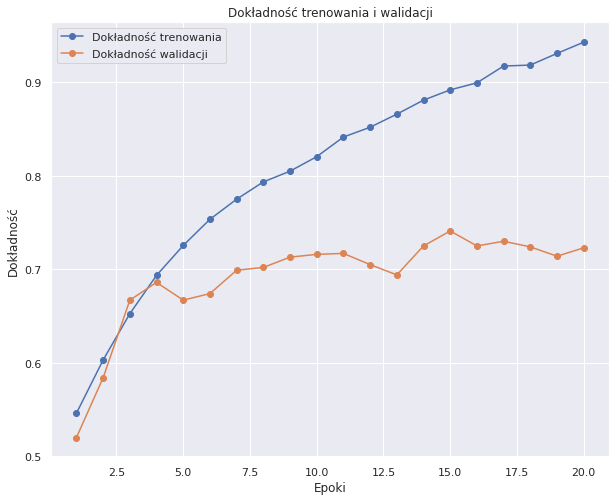

In [15]:
make_accuracy_plot(history)

### Training and validation loss graph

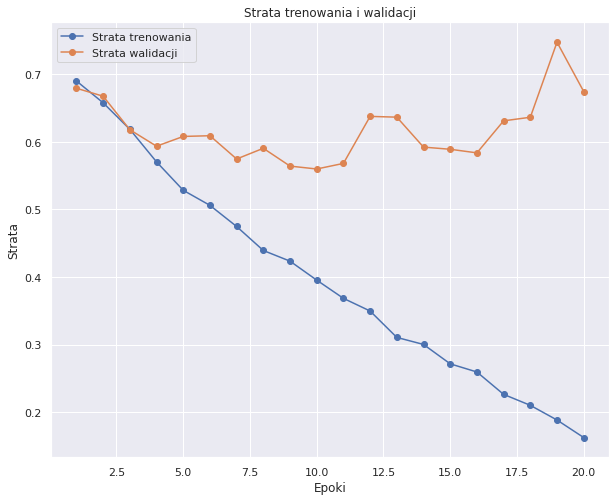

In [16]:
make_loss_plot(history)

### Data Augmentation

Particularly useful in cases of insufficient training data. It consists in various transformations of the input data through operations such as cropping, rotation or zooming in order to generate new input data.




### Building a model using images generated using data augmentation

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

# nie modyfikujemy danych walidacyjnych!!!
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.



### Model training

In [22]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=100,
                             epochs=20,    # 100
                             validation_data=valid_generator,
                             validation_steps=50)

Epoch 1/20
100/100 [==============================] - 20s 185ms/step - loss: 0.7306 - accuracy: 0.5085 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 2/20
100/100 [==============================] - 19s 187ms/step - loss: 0.6946 - accuracy: 0.5005 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 19s 187ms/step - loss: 0.6938 - accuracy: 0.5125 - val_loss: 0.6903 - val_accuracy: 0.5040
Epoch 4/20
100/100 [==============================] - 19s 186ms/step - loss: 0.6924 - accuracy: 0.5310 - val_loss: 0.6805 - val_accuracy: 0.6100
Epoch 5/20
100/100 [==============================] - 21s 207ms/step - loss: 0.6820 - accuracy: 0.5840 - val_loss: 0.6634 - val_accuracy: 0.6450
Epoch 6/20
100/100 [==============================] - 18s 184ms/step - loss: 0.6723 - accuracy: 0.6005 - val_loss: 0.6454 - val_accuracy: 0.6050
Epoch 7/20
100/100 [==============================] - 19s 191ms/step - loss: 0.6658 - accuracy: 0.6325 - val_loss: 0.6587 - val_ac

### Save model to file

In [23]:
model.save('cats_and_dogs_small_2.h5')

### Training and validation accuracy graph

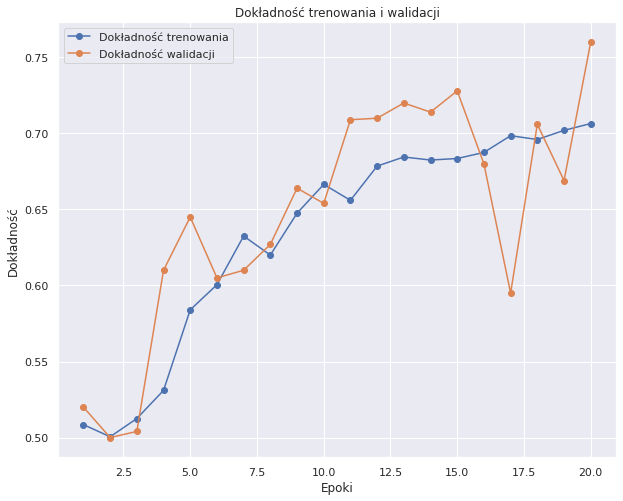

In [23]:
make_accuracy_plot(history)

### Training and validation loss graph

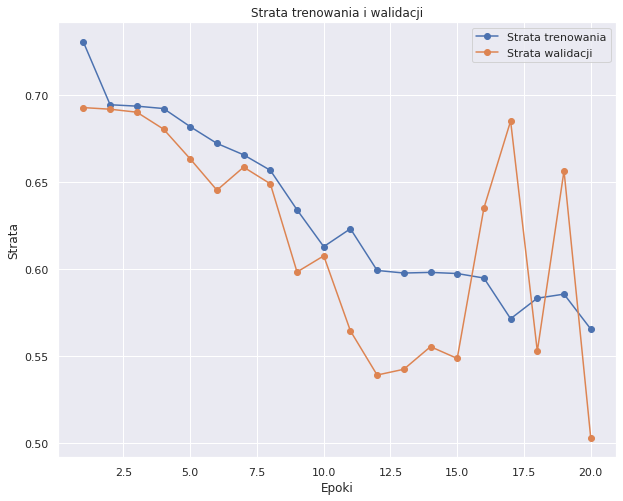

In [24]:
make_loss_plot(history)

### Transfer Learning - 

is based on the use of an already overtrained model, usually on a very large input set, 
We will use the architecture of the VGG16 model (containing 16 layers) trained on the `Imagenet` set. 
The Imagenet collection consists of 1.4 million images divided into 1000 classes, which also include different breeds of dogs and cats. 
The finished model is available in the Keras library.

In [25]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,    # czy dołączyć górną cześć sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                 input_shape=(150, 150, 3))

conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

## Feature extraction with data augmentation

We will use the advantages of Transfer Learning as well as data augmentation techniques. We will add the last three layers to the downloaded model: a Flatten layer and two dense layers (Dense).

In [26]:
from keras import models
from keras import layers


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### Train the model from start to finish with a frozen convolutional base

We will now freeze the weights of the VGG16 network to prevent these weights from being updated in the training process. If we did not, the features that the model learned could be modified during training

In [27]:
print('Liczba wag poddawanych trenowaniu przed zamrożeniem bazy:', len(model.trainable_weights))
conv_base.trainable = False
print('Liczba wag poddawanych trenowaniu po zamrożeniu bazy', len(model.trainable_weights))

Liczba wag poddawanych trenowaniu przed zamrożeniem bazy: 30
Liczba wag poddawanych trenowaniu po zamrożeniu bazy 4


### Data augmentation stage

In [28]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers


train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# dane walidacyjne nie mogą być modyfikowane!!!
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Compilation and training of an extended model (excluding convolution layers)



In [29]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=50,
                             validation_data=valid_generator,
                             validation_steps=50,
                             verbose=2)

Epoch 1/50
100/100 - 22s - loss: 0.5846 - accuracy: 0.6930 - val_loss: 0.4429 - val_accuracy: 0.8380 - 22s/epoch - 222ms/step
Epoch 2/50
100/100 - 20s - loss: 0.4859 - accuracy: 0.7730 - val_loss: 0.3686 - val_accuracy: 0.8560 - 20s/epoch - 200ms/step
Epoch 3/50
100/100 - 20s - loss: 0.4300 - accuracy: 0.8135 - val_loss: 0.3275 - val_accuracy: 0.8790 - 20s/epoch - 196ms/step
Epoch 4/50
100/100 - 19s - loss: 0.3984 - accuracy: 0.8215 - val_loss: 0.3105 - val_accuracy: 0.8770 - 19s/epoch - 193ms/step
Epoch 5/50
100/100 - 20s - loss: 0.3869 - accuracy: 0.8330 - val_loss: 0.2943 - val_accuracy: 0.8760 - 20s/epoch - 198ms/step
Epoch 6/50
100/100 - 19s - loss: 0.3640 - accuracy: 0.8520 - val_loss: 0.2789 - val_accuracy: 0.8960 - 19s/epoch - 191ms/step
Epoch 7/50
100/100 - 20s - loss: 0.3543 - accuracy: 0.8495 - val_loss: 0.2797 - val_accuracy: 0.8870 - 20s/epoch - 200ms/step
Epoch 8/50
100/100 - 21s - loss: 0.3332 - accuracy: 0.8590 - val_loss: 0.2653 - val_accuracy: 0.8990 - 21s/epoch - 208

### Accuracy Level Verification

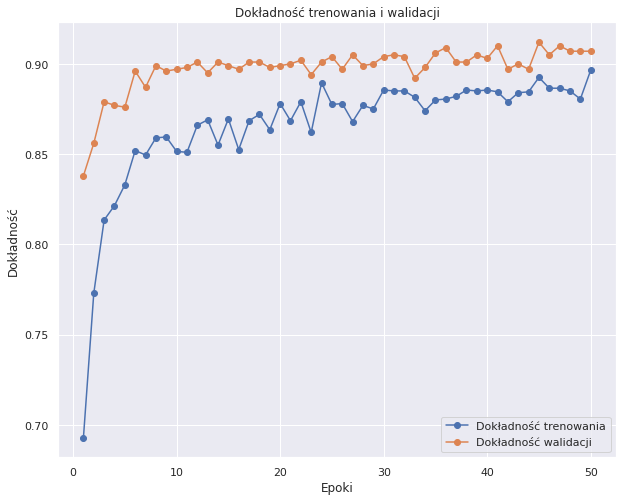

In [30]:
make_accuracy_plot(history)

### Loss function distribution

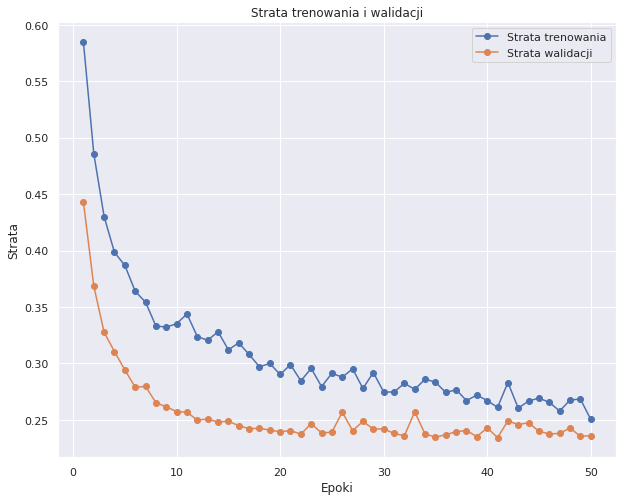

In [31]:
make_loss_plot(history)

### Tuning



This technique consists in 'unfreezing' several upper layers of the frozen base of the model. We will tune the last three convolutional layers (`block5_conv1, block5_conv2, block5_conv3`).



In [32]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,    # czy dołączyć górną cześć sieci, jeżeli True dołączy gęsto połączoną warstwę z 1000 klas
                 input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [33]:
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print('layer_name: {:12}, trainable: {}'.format(layer.name, layer.trainable))
        
print_layers(conv_base)        

layer_name: input_2     , trainable: True
layer_name: block1_conv1, trainable: True
layer_name: block1_conv2, trainable: True
layer_name: block1_pool , trainable: True
layer_name: block2_conv1, trainable: True
layer_name: block2_conv2, trainable: True
layer_name: block2_pool , trainable: True
layer_name: block3_conv1, trainable: True
layer_name: block3_conv2, trainable: True
layer_name: block3_conv3, trainable: True
layer_name: block3_pool , trainable: True
layer_name: block4_conv1, trainable: True
layer_name: block4_conv2, trainable: True
layer_name: block4_conv3, trainable: True
layer_name: block4_pool , trainable: True
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [34]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print_layers(conv_base)         

layer_name: input_2     , trainable: False
layer_name: block1_conv1, trainable: False
layer_name: block1_conv2, trainable: False
layer_name: block1_pool , trainable: False
layer_name: block2_conv1, trainable: False
layer_name: block2_conv2, trainable: False
layer_name: block2_pool , trainable: False
layer_name: block3_conv1, trainable: False
layer_name: block3_conv2, trainable: False
layer_name: block3_conv3, trainable: False
layer_name: block3_pool , trainable: False
layer_name: block4_conv1, trainable: False
layer_name: block4_conv2, trainable: False
layer_name: block4_conv3, trainable: False
layer_name: block4_pool , trainable: False
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [35]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________



### Model training

In [36]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=50,
                             validation_data=valid_generator,
                             validation_steps=50)

Epoch 1/50
100/100 [==============================] - 22s 209ms/step - loss: 0.5296 - accuracy: 0.7345 - val_loss: 0.3223 - val_accuracy: 0.8710
Epoch 2/50
100/100 [==============================] - 21s 207ms/step - loss: 0.3750 - accuracy: 0.8335 - val_loss: 0.2560 - val_accuracy: 0.8920
Epoch 3/50
100/100 [==============================] - 20s 199ms/step - loss: 0.3207 - accuracy: 0.8620 - val_loss: 0.2248 - val_accuracy: 0.9010
Epoch 4/50
100/100 [==============================] - 24s 236ms/step - loss: 0.2785 - accuracy: 0.8815 - val_loss: 0.2178 - val_accuracy: 0.9060
Epoch 5/50
100/100 [==============================] - 21s 210ms/step - loss: 0.2619 - accuracy: 0.8825 - val_loss: 0.2192 - val_accuracy: 0.9080
Epoch 6/50
100/100 [==============================] - 22s 216ms/step - loss: 0.2614 - accuracy: 0.8950 - val_loss: 0.2091 - val_accuracy: 0.9140
Epoch 7/50
100/100 [==============================] - 21s 205ms/step - loss: 0.2345 - accuracy: 0.9010 - val_loss: 0.2022 - val_ac

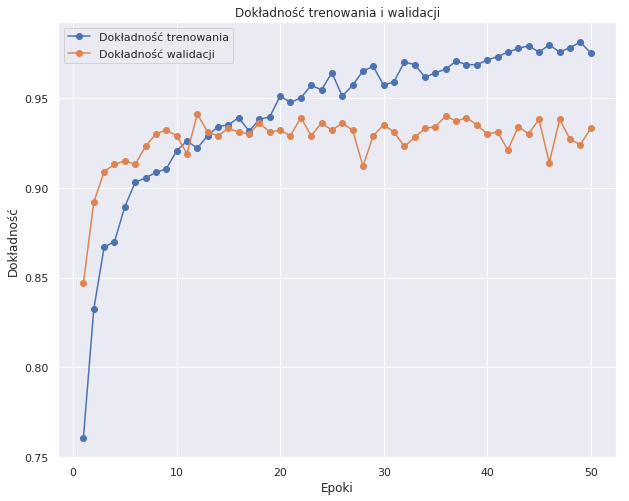

In [ ]:
make_accuracy_plot(history)

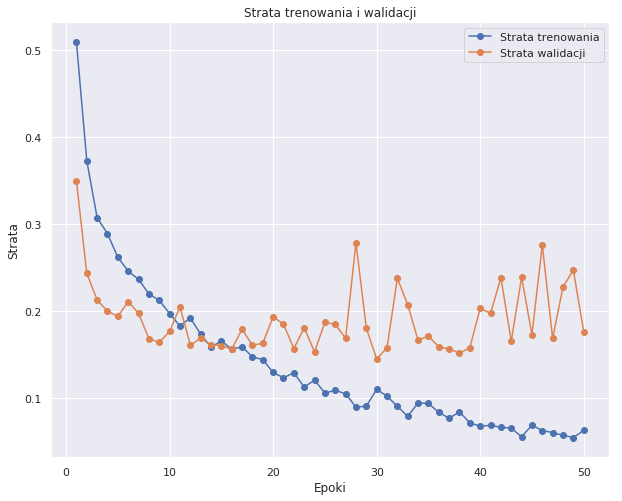

In [ ]:
make_loss_plot(history)

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Dokładność testowania:', test_acc)

Found 1000 images belonging to 2 classes.
Dokładność testowania: 0.931999990940094


## Visualization of learning effects of convolutional networks

* visualization of intermediate inputs
* visualization of convolutional network filters
* visualization of heat map activation image classes



### Visualization of intermediate inputs

It consists in displaying feature maps that are generated by various convolutional layers.



In [ ]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
#@title Wybierz indeks obrazka:
index = 1559 #@param {type:'slider', min:1500, max:1999}
img_path = '/content/cats_and_dogs/test/cats/cat.' + str(index) + '.jpg'

from keras.preprocessing import image
import numpy as np

# przetwarzamy obraz tak aby uzyskał formę czterowymiaorwego tensora
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


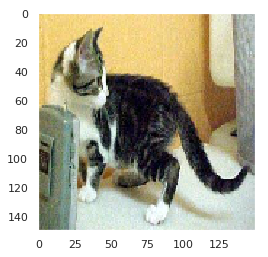

In [ ]:
plt.imshow(img_tensor[0])
plt.grid(False)

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


### Display feature maps

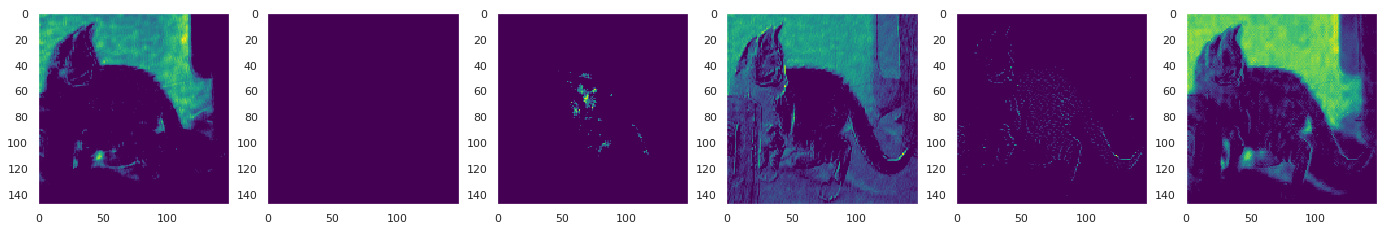

In [ ]:
plt.figure(figsize=(24, 24))

for i in range(1, 7):
    plt.subplot(1, 6, i)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.grid(False)


### Visualization of all channels of each intermediate activation layer

The first layer detects such low-level elements as edges, etc. At this stage, activations retain almost all information present in the input image. The next layers become more and more abstract and more difficult to interpret graphically. They allow you to encode high-level features such as 'cat's ear', 'cat's eye'. Higher layers contain less and less information about the visual content of the image and at the same time contain more and more information related to the image's class

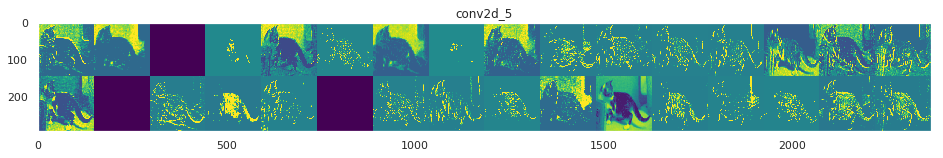

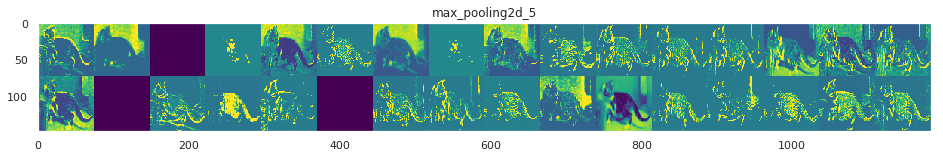

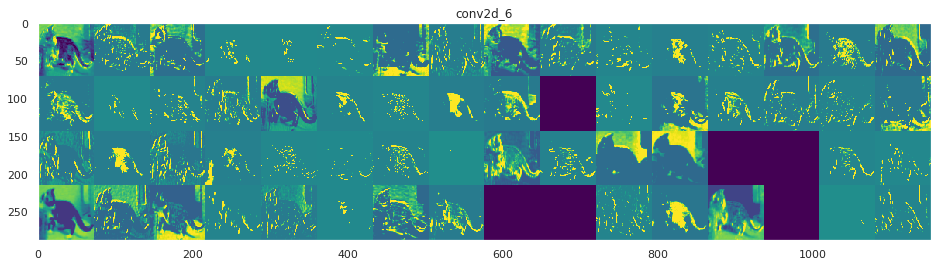

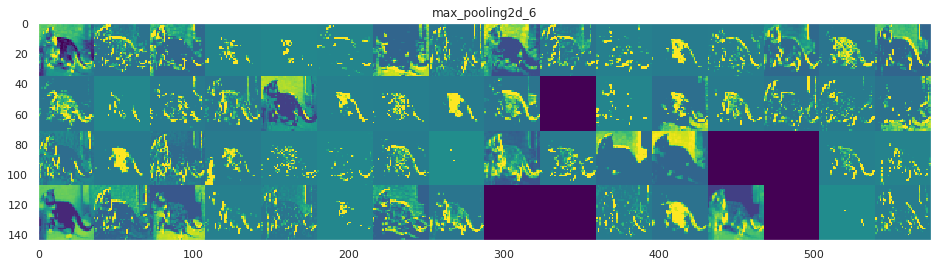

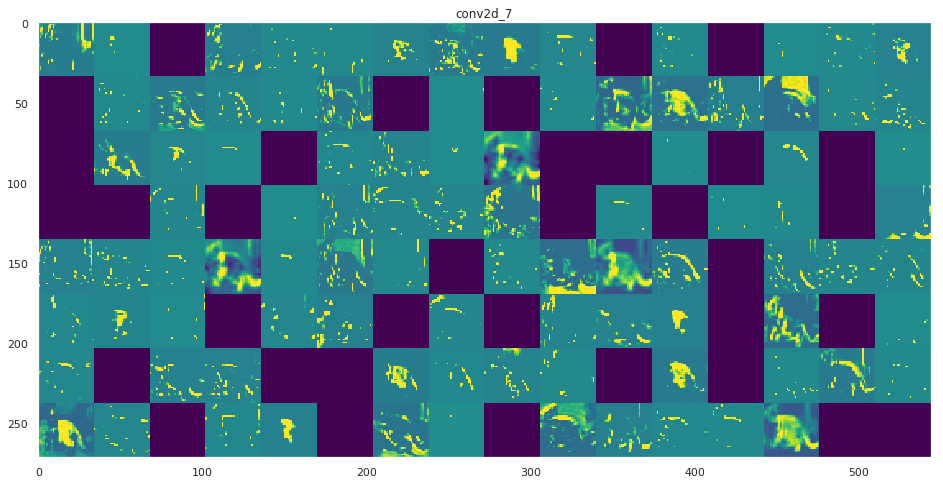

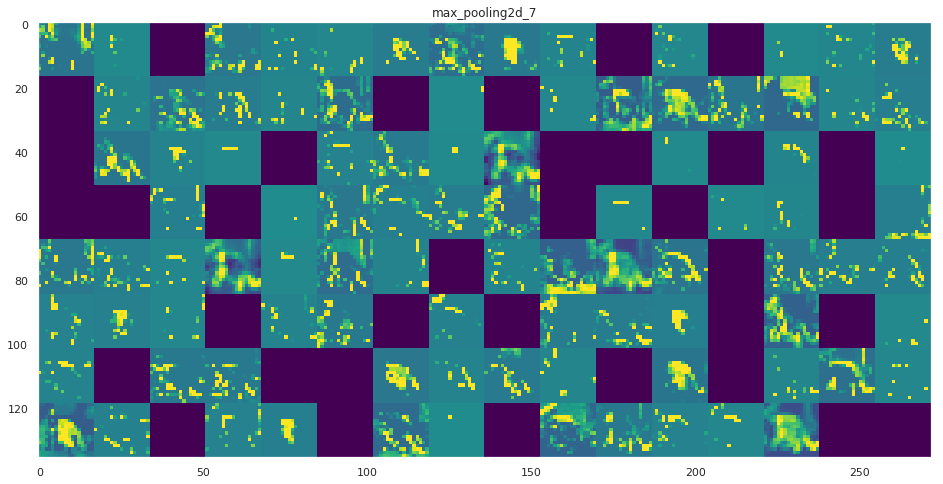

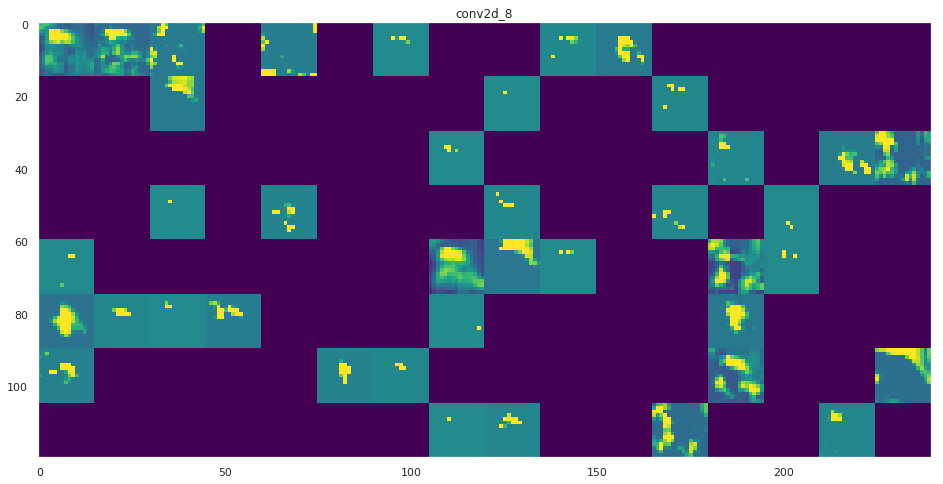

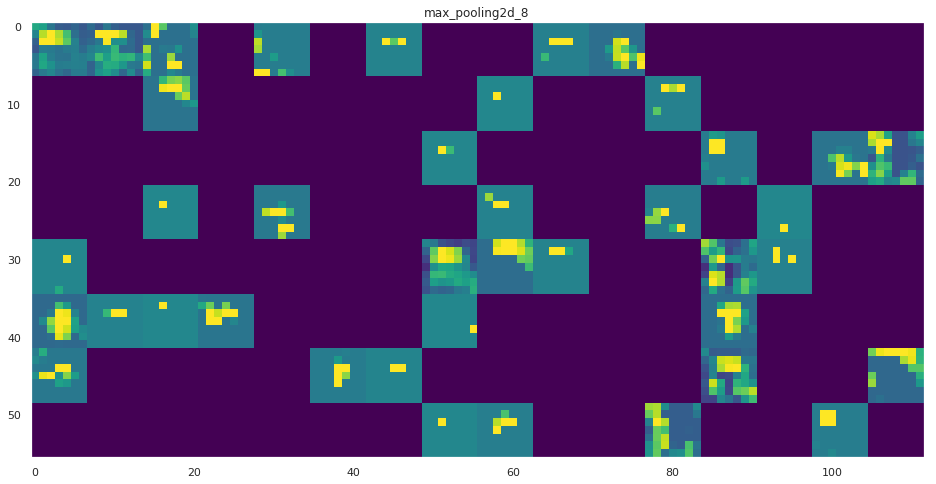

In [ ]:
layer_names = [layer.name for layer in model.layers[:8]]

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size, row * size: (row+ + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


### Visualization of convolutional neural network filters

A convolutional filter is a graphical pattern to which the given filter reacts.



In [ ]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
             include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss,grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150 , 3))])

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.

for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step
    
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Display of some sample filters



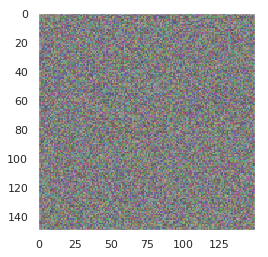

In [ ]:
#@title Wybierz warstwę:
layer = 'block5_conv1' #@param ['block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']
plt.imshow(generate_pattern(layer, 1))
plt.grid(False)

### Class activation heat map visualizations

Finally, a very useful visualization technique. It is extremely helpful in the model debugging process. It allows us to determine on the basis of which part of the image the model made a certain decision. Useful for exploring misclassified images.

For this purpose, we will use the implementation described in the article [`Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization`](https://arxiv.org/abs/1610.02391).



553467904/553467096 [==============================] - 16s 0us/step


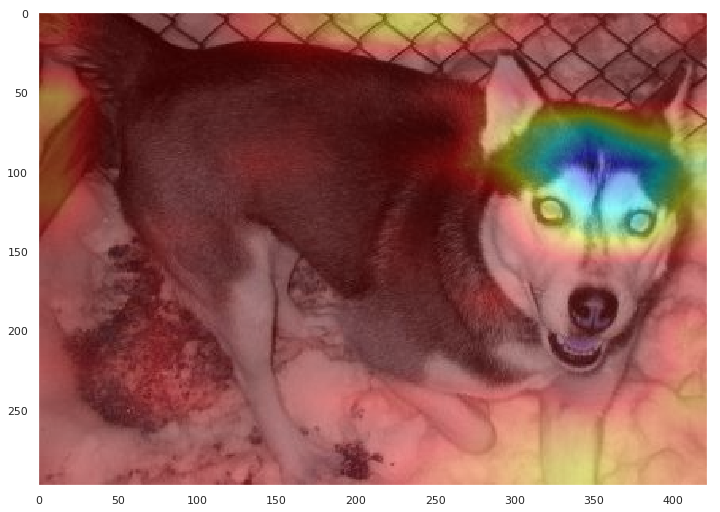

In [ ]:
#@title Wybierz numer indeksu zdjęcia
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

pets = 'dogs' #@param ['cats', 'dogs']
index = 1748 #@param {'type': 'slider', min :1500, max: 1999}

model = VGG16(weights="imagenet")
img_path = '/content/cats_and_dogs/test/' + pets + '/' + pets[:3] + '.' + str(index) + '.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.imshow(superimposed_img, cmap='viridis')
plt.grid(False)
plt.show()

The areas marked in the image as the 'bluer' ones had a strong influence on the final prediction of the model. For example, for index No. 1748, the algorithm very accurately indicated that when making a decision, it was guided by the area of ​​​​the image in which the head of the dog (in this case, the Husky breed) was included. Perhaps what allowed the network to decide on the category of the image were features such as the shape/color of the eyes or the color of the fur around the eyes.

##Conclusions

* Convolutional neural networks are the best machine learning models for image processing tasks
* Convolutional networks can be trained even on small data sets, for this purpose data augmentation and transfer learning are helpful (example: medical photos)
* The possibility of using transfer learning allows you to train models in a much shorter time with much greater efficiency of such a model compared to a model based only on the data we have
* Tuning techniques allow you to adapt previously learned models to our problem, which should in fact lead to improved model performance
* As it is commonly believed about neural networks as "black boxes", in the case of convolutional networks, the individual stages of the network's operation are easy to visualize.

> Thanks to the use of various model optimization techniques (data augmentation, transfer learning) from the base model with an accuracy level of approx. 73%, it was possible to obtain a model with an accuracy of approx. 93%, which is a very satisfactory result.

